In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, pprint, h5py, emoji
from tqdm import tqdm
import numpy as np
from glob import glob
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from mpl_toolkits.axes_grid.inset_locator import inset_axes

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Two electrons in a purely harmonic well

In [133]:
xc = np.arange(-1E-6, 1E-6, 2E-9)
xd = np.arange(-1E-6, 1E-6, 2E-9)

hbar = 1.055E-34
me = 9.11E-31
qe = 1.602E-19
eps0 = 8.85E-12

dxd = np.diff(xd)[0]
dxc = np.diff(xc)[0]

def trap_curv(V, f_trap):
    omega_trap = 2 * np.pi * f_trap
    k0 = me * omega_trap ** 2 / qe
    return k0 * V

In [134]:
trap_curv(1, 10E9)

22449961571.516617

We split up the motion of the electrons in two parts. Firstly, there is a center-of-mass motion, where the electrons move in phase. We parameterize this motion with the coordinate $x_c = x_1 + x_2$, where $x_1$ and $x_2$ are the physical coordinates of each particle in the potential landscape. Secondly, there is the differential motion, where electrons move out of phase. This motion is parameterized by $x_d = x_1 - x_2$. It turns out that the equations come out nicely, since the electron-electron interaction term has a dependence only on $|x_1 - x_2| = |x_d|$ and we can write the potential energies of the particle in terms of $x_c$ and $x_d$ very easily as well. By using separation of variables we can split up these two equations ans solve for the differential and center-of-mass motion separately. We'll solve te center-of-mass mode first. Here it goes:

## Center-of-mass mode

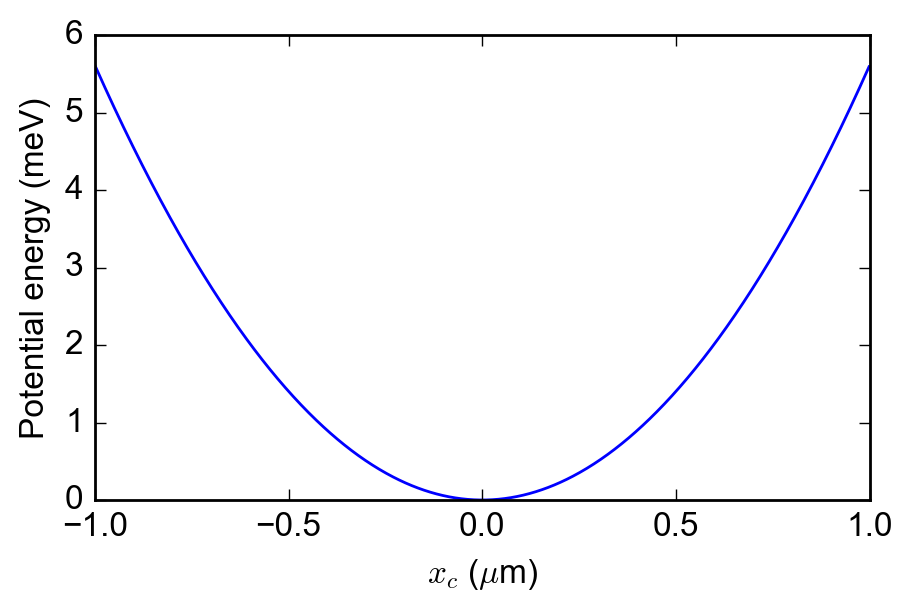

In [135]:
def Uc(x, V, f_trap):
    return 1/4. * trap_curv(V, f_trap) * qe * np.diag(x**2)

def setup_eqs(xc, V, f_trap):
    
    second_deriv = -np.diag(hbar**2/(me*dxc**2) * np.ones(len(xc)-1),k=-1) +\
                   -np.diag(hbar**2/(me*dxc**2) * np.ones(len(xc)-1),k=+1) + \
                   +np.diag(2*hbar**2/(me*dxc**2) * np.ones(len(xc)))

    return second_deriv + Uc(xc, V, f_trap)

plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(xc * 1E6, 1E3 * np.diag(Uc(xc, 1.0, 10E9))/qe)
plt.xlabel("$x_c$ ($\mu$m)")
plt.ylabel("Potential energy (meV)")

In [136]:
V_trap = 1.0
f_trap = 10E9

evals, evecs = np.linalg.eig(setup_eqs(xc, V_trap, f_trap))

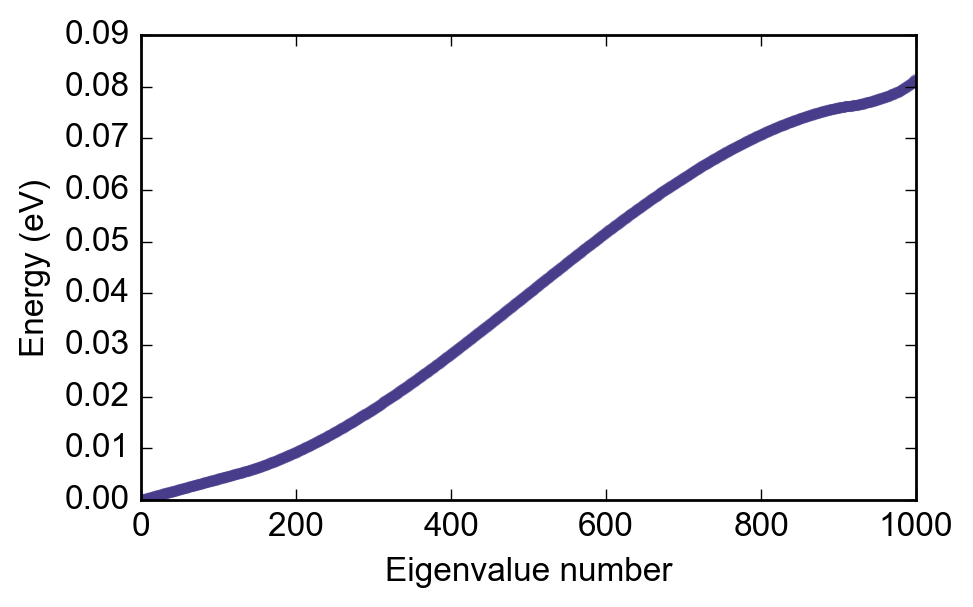

In [137]:
order = np.argsort(evals)

plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(evals[order]/qe, 'o', **common.plot_opt(color='darkslateblue', msize=3))
plt.xlabel("Eigenvalue number")
plt.ylabel("Energy (eV)")

Since we're looking at a harmonic potential, it makes sense that the eigenvalues lie on a straight line. This means that their energy separation is constant, so we retrieve the equidistant energy ladder. We can check the spacing by printing out the first four energy levels. The first energy level is given by $$E_0 = \frac{1}{2} \hbar \omega$$and all successive energy levels should be spaced by $$\hbar \omega$$ Some deviation from the straight line is visible for higher energies, where you notice that the potential is truncated beyond a certain $x$, in this case $1.0 \mu$m. We're only interested in the first few states, so we can neglect these effects safely. 

In [138]:
np.sqrt(trap_curv(1.0, f_trap) * qe / me)*1 / (2 * np.pi * 1E9)

10.0

E0/h = 5.00 GHz
(E1 - E0)/h = 10.00 GHz
(E2 - E1)/h = 10.00 GHz


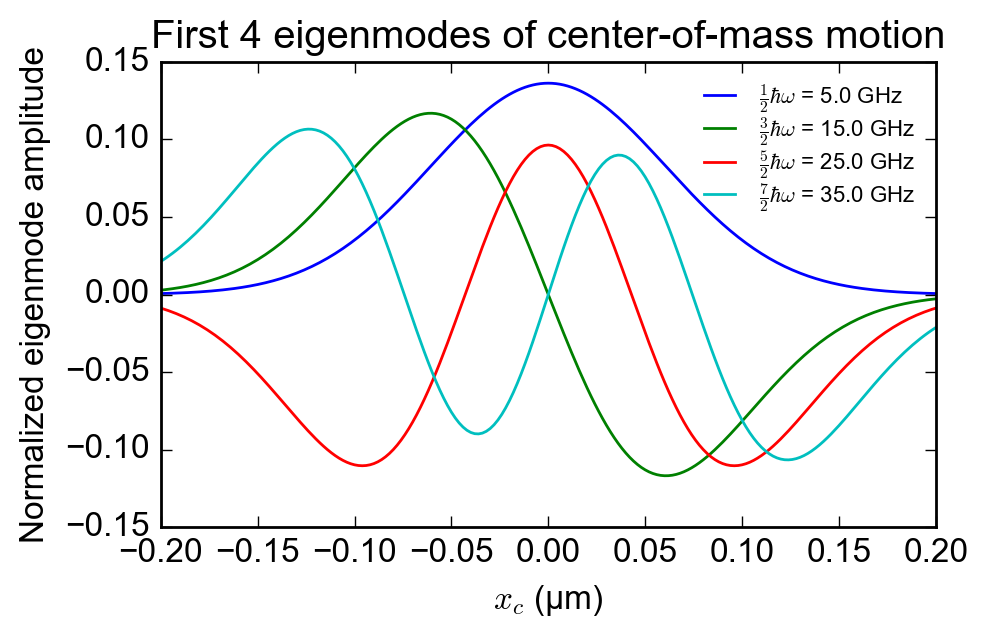

In [139]:
fig = plt.figure(figsize=(5.,3.))
common.configure_axes(12)
for n in range(4):
    plt.plot(xc*1E6, evecs[:,order[n]], 
             label=r"$\frac{%d}{2}\hbar \omega$ = %.1f GHz"%((2*n+1), evals[order[n]]/(2*np.pi*hbar*1E9)))
    #print(evals[order[n]]/(2*np.pi*hbar*1E9))

print("E0/h = %.2f GHz"%((evals[order[0]]/(2*np.pi*hbar*1E9))))
print("(E1 - E0)/h = %.2f GHz"%((evals[order[1]]-evals[order[0]])/(2*np.pi*hbar*1E9)))
print("(E2 - E1)/h = %.2f GHz"%((evals[order[2]]-evals[order[1]])/(2*np.pi*hbar*1E9)))
    
plt.legend(loc=0, prop={"size" : 8}, frameon=False)
plt.xlim(-0.2, +0.2)
plt.xlabel('$x_c$ (%sm)' % (chr(956)))
plt.ylabel('Normalized eigenmode amplitude')
plt.title('First 4 eigenmodes of center-of-mass motion')

# common.save_figure(fig, save_path=r"/Users/gkoolstra/Google Drive/grad school/schuster lab/notes/Pictures")

([], <a list of 0 Text yticklabel objects>)

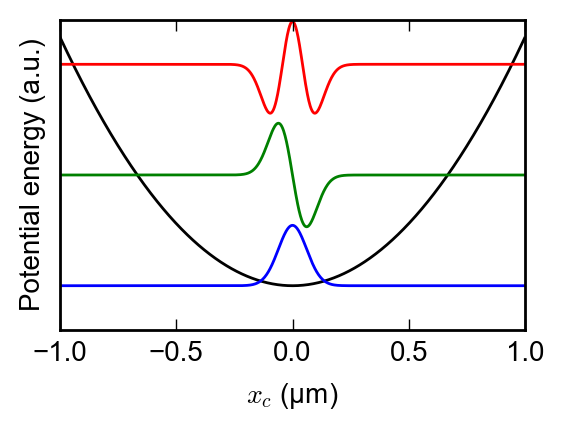

In [140]:
plt.figure(figsize=(3.,2.))
common.configure_axes(10)
plt.plot(xc * 1E6, 1E3 * np.diag(Uc(xc, 1.0, 10E9)) / qe, 'k')
plt.xlabel("$x_c$ (%sm)" % (chr(956)))
plt.ylabel("Potential energy (a.u.)")

for n in range(3):
    offset = n*2.5
    plt.plot(xc * 1E6, offset + evecs[:,order[n]] * 10, )
#     plt.hlines(offset, -1, 1, linestyles='-', color='gray')
    
plt.yticks([])

In [141]:
hbar * 2 * np.pi * f_trap / qe

4.137803058098916e-05

The eigenmodes depicted above represent the first of the <a href=https://en.wikipedia.org/wiki/Quantum_harmonic_oscillator#Natural_length_and_energy_scales>Eigenmodes of the harmonic oscillator</a> which have a close relation with the <a href=https://en.wikipedia.org/wiki/Hermite_polynomials>_Hermite polynomials_</a>.

## Differential mode

(0.001, 1.0)

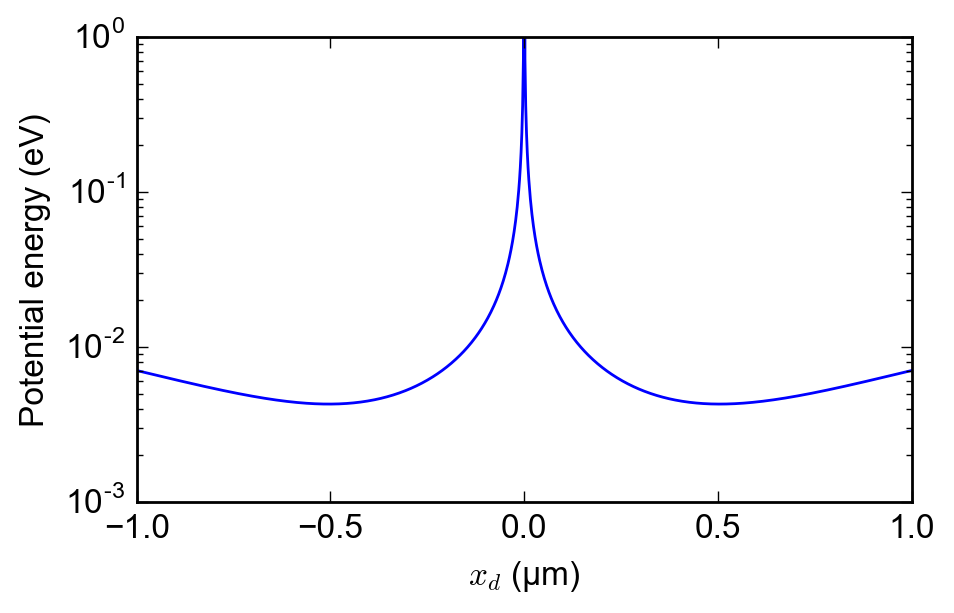

In [142]:
def Ud(xd, V, f_trap):
    return 1/4. * trap_curv(V, f_trap) * qe * np.diag(xd**2) + qe**2 / (4*np.pi*eps0) * np.diag(1/(np.abs(xd)))

def setup_diff_eqs(xd, V, f_trap):
    second_deriv = -np.diag(hbar**2/(me*dxd**2) * np.ones(len(xd)-1),k=-1) +\
                   -np.diag(hbar**2/(me*dxd**2) * np.ones(len(xd)-1),k=+1) + \
                   +np.diag(2*hbar**2/(me*dxd**2) * np.ones(len(xd)))

    return second_deriv + Ud(xd, V, f_trap)
        
plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(xd*1E6, np.diag(Ud(xd, V_trap, f_trap)) / qe)
plt.xlabel("$x_d$ (%sm)" % (chr(956)))
plt.ylabel("Potential energy (eV)")
plt.yscale('log')
plt.ylim(1E-3, 1E0)

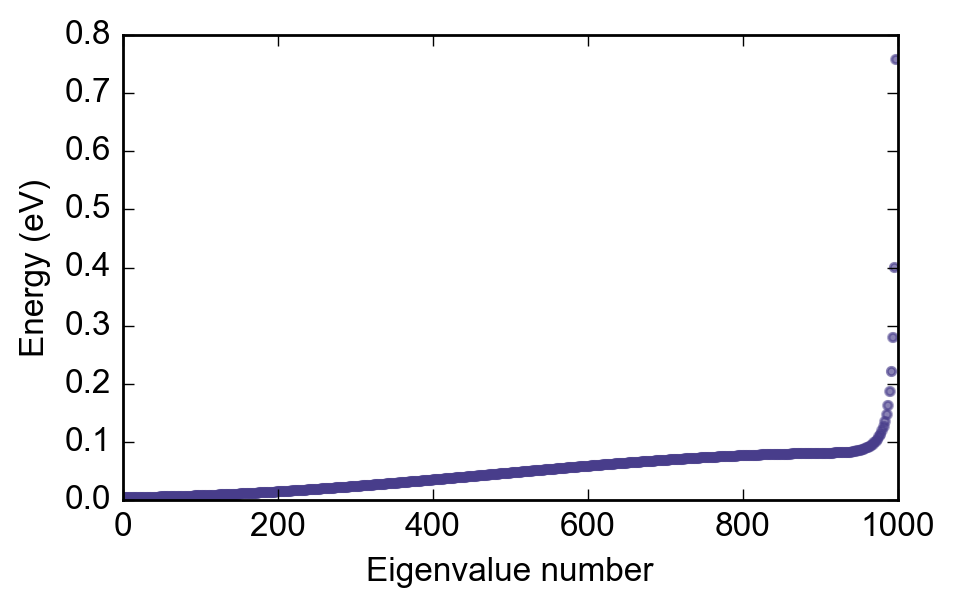

In [143]:
evals_d, evecs_d = np.linalg.eig(setup_diff_eqs(xd, 1.0, f_trap))
order_d = np.argsort(evals_d)

plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(evals_d[order_d][:-1]/qe, 'o', **common.plot_opt(color='darkslateblue', msize=3))
plt.xlabel("Eigenvalue number")
plt.ylabel("Energy (eV)")

(E2 - E0)/h = 17.34 GHz
(E4 - E2)/h = 17.36 GHz


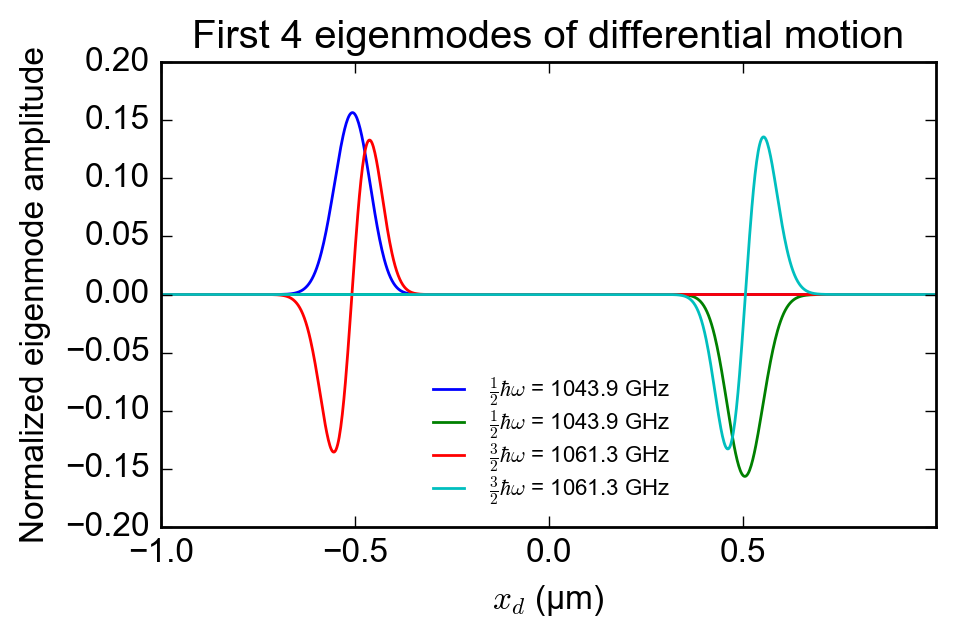

In [161]:
fig = plt.figure(figsize=(5.,3.))
common.configure_axes(12)

for m, n in zip([0, 0, 1, 1], range(4)):
    plt.plot(xd * 1E6, evecs_d[:,order_d[n]], 
             label=r"$\frac{%d}{2}\hbar \omega$ = %.1f GHz"%((2*m+1), evals_d[order_d[n]]/(2*np.pi*hbar*1E9)))

print("(E2 - E0)/h = %.2f GHz"%((evals_d[order_d[2]]-evals_d[order_d[0]])/(2*np.pi*hbar*1E9)))
print("(E4 - E2)/h = %.2f GHz"%((evals_d[order_d[4]]-evals_d[order_d[2]])/(2*np.pi*hbar*1E9)))

plt.legend(loc=0, prop={"size" : 8}, frameon=False)
plt.xlim(np.min(xd) * 1e6, np.max(xd) * 1e6)
plt.xlabel('$x_d$ (%sm)' % (chr(956)))
plt.ylabel('Normalized eigenmode amplitude')
plt.title('First 4 eigenmodes of differential motion')

# common.save_figure(fig, save_path=r"/Users/gkoolstra/Google Drive/grad school/schuster lab/notes/Pictures")

([], <a list of 0 Text yticklabel objects>)

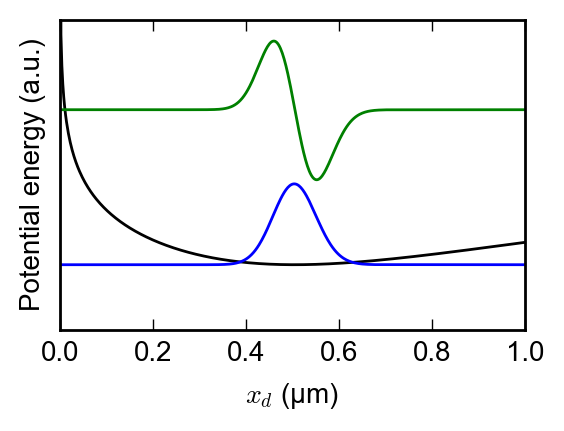

In [162]:
plt.figure(figsize=(3.,2.))
common.configure_axes(10)
plt.plot(xd*1E6, np.log10(np.diag(Ud(xd, V_trap, f_trap)) / qe), 'k')
plt.xlabel("$x_d$ (%sm)" % (chr(956)))
plt.ylabel("Potential energy (a.u.)")

for m, n in zip([0, 0, 1, 1], range(4)):
    offset = np.min(np.log10(np.diag(Ud(xd, V_trap, f_trap)) / qe)) + m * 1.5
    
    if not(n%2):
        plt.plot(xd[::-1] * 1E6, offset + evecs_d[:,order_d[n]] * 5)

plt.ylim(-3, 0)
plt.xlim(0, 1)
# plt.yscale('log')
    
# for n in range(3):
#     offset = n*2.5
#     plt.plot(xd * 1E6, offset + evecs[:,order[n]] * 10, )
#     plt.hlines(offset, -1, 1, linestyles='-', color='gray')
    
plt.yticks([])

Again these are the eigenstates of an almost-harmonic oscillator. Now however, we have degenerate states that are related by the transformation $x_d \rightarrow -x_d$. This just amounts to swapping the position of particle 1 and 2, so these states should have the same energy. In fact, it may be better to plot this as a function of $|x_d|$ 

$E_0$ has a large offset due to the Coulomb repulsion.

Let us now check the most probable value that we observe in the plot above. In 1D, the classical separation calculated from minimizing the energy is given by  
$$ x_d^{\max} = x_1 - x_2 = 2x_1 = 2 \left(\frac{1}{4\pi \epsilon_0}\frac{e}{4k} \right)^{\frac{1}{3}} $$
This corresponds to the maximum of the wave function that's depicted above. We can evaluate this numerically to see that it indeed corresponds to the value of $x_d$ where the peak occurs: 

In [128]:
2*(qe/(4*np.pi*eps0*trap_curv(1.0, f_trap)*4))**(1/3.)

5.04399433631222e-07

Wavefunction extension $\ell_0$

In [163]:
np.sqrt(hbar / (2 * np.pi * f_trap * me))

4.2931603245293574e-08

Electron separation from classical calculation: $r$

In [58]:
(2 * qe ** 2 / (4 * np.pi * eps0 * me * (2 * np.pi * f_trap) ** 2)) ** (1/3.)

1.0866956374475397e-07

We can now add a non-linearity to the potential in the form of a quartic term in the potential. 

# Two electrons in a _anharmonic_ well, includes quartic potential term

## Center of mass mode 

Double well is expected at positions +/- 0.15 um


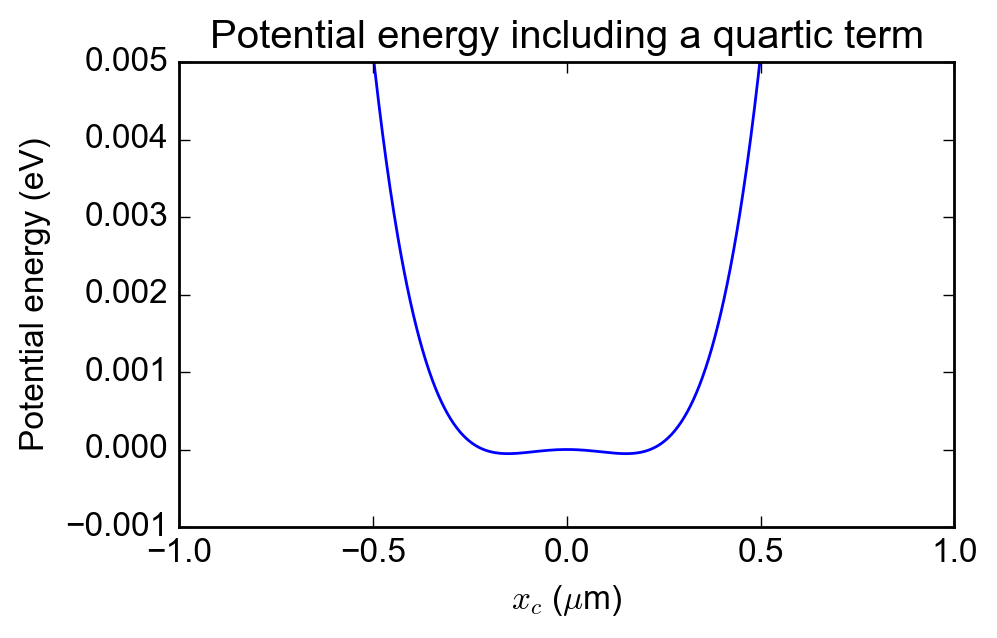

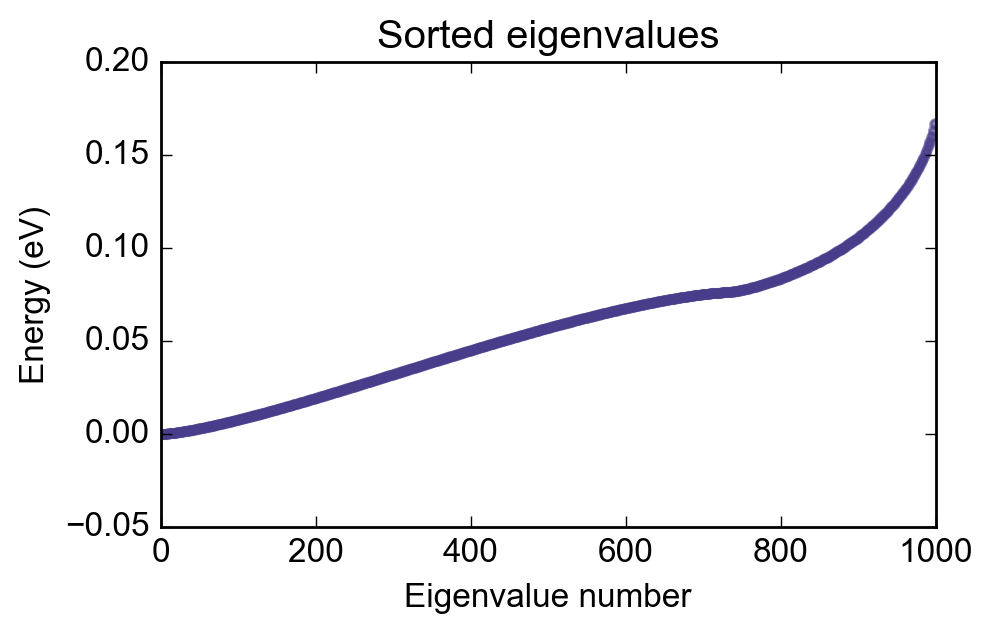

In [60]:
def trap_curv(V):
    k0 = -0.0185E12
    return k0 * V

def quartic(V):
    k0 = +0.4E24 #+0.442E24
    return k0 * V

if np.sign(quartic(1.0)) != np.sign(trap_curv(1.0)) and quartic(1.0) != 0:
    print("Double well is expected at positions +/- %.2f um" % (np.sqrt(trap_curv(1.0)/(-2*quartic(1.0))) * 1E6))
    
def Uc_quartic(x, V):
    return 1/4. *  qe * (trap_curv(V) * np.diag(x**2) + quartic(V) * np.diag(x**4))

def setup_eqs(xc, V):
    second_deriv = -np.diag(hbar**2/(me*dxc**2) * np.ones(len(xc)-1),k=-1) +\
                   -np.diag(hbar**2/(me*dxc**2) * np.ones(len(xc)-1),k=+1) + \
                   +np.diag(2*hbar**2/(me*dxc**2) * np.ones(len(xc)))

    return second_deriv + Uc_quartic(xc,V)

evals, evecs = np.linalg.eig(setup_eqs(xc, 1.0))
order = np.argsort(evals)

plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(xc*1E6, np.diag(Uc_quartic(xc, 1.0)) / qe)
plt.title("Potential energy including a quartic term")
# for n in range(3):
#     plt.hlines(evals[order[n]]/qe, -1, 1)
plt.xlabel("$x_c$ ($\mu$m)")
plt.ylabel("Potential energy (eV)")
plt.ylim(-0.001, 0.005)

plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.title("Sorted eigenvalues")
plt.plot(evals[order]/qe, 'o', **common.plot_opt(color='darkslateblue', msize=3))
plt.xlabel("Eigenvalue number")
plt.ylabel("Energy (eV)")

E0/h = -7.14 GHz
(E1 - E0)/h = 0.30 GHz
(E2 - E1)/h = 7.97 GHz
The anharmonicity is 7667 MHz


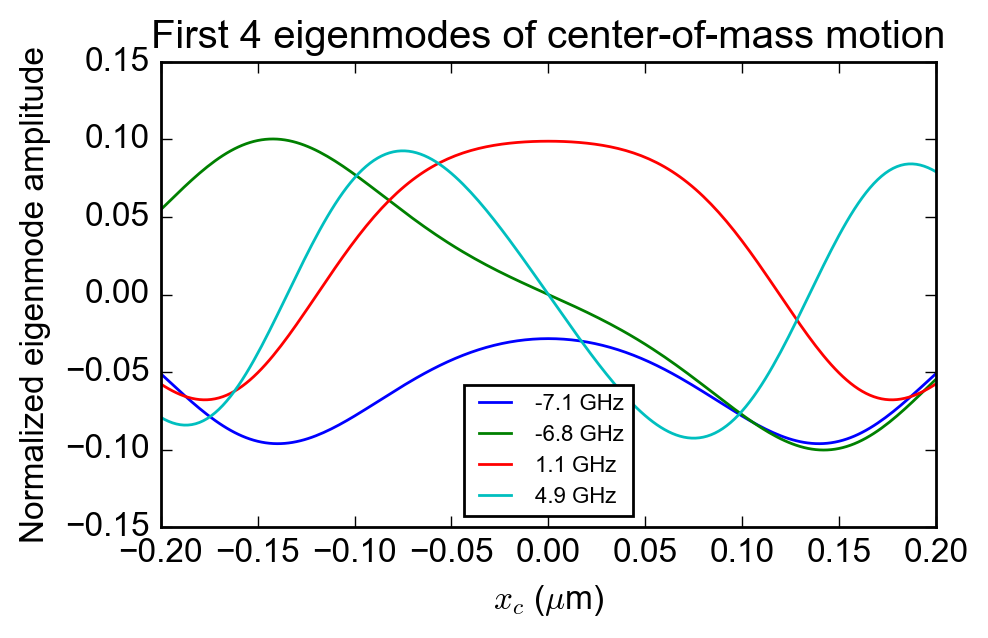

In [61]:
plt.figure(figsize=(5.,3.))
common.configure_axes(12)
for n in range(4):
    plt.plot(xc*1E6, evecs[:,order[n]], label="%.1f GHz"%(evals[order[n]]/(2*np.pi*hbar*1E9)))
    #print(evals[order[n]]/(2*np.pi*hbar*1E9))

print("E0/h = %.2f GHz"%((evals[order[0]]/(2*np.pi*hbar*1E9))))
print("(E1 - E0)/h = %.2f GHz"%((evals[order[1]]-evals[order[0]])/(2*np.pi*hbar*1E9)))
print("(E2 - E1)/h = %.2f GHz"%((evals[order[2]]-evals[order[1]])/(2*np.pi*hbar*1E9)))
print("The anharmonicity is %.0f MHz"%(((evals[order[2]]-evals[order[1]]) - (evals[order[1]]-evals[order[0]]))/(2*np.pi*hbar*1E6)))
    
plt.legend(loc=0, prop={"size" : 8})
plt.xlim(-0.2, +0.2)
plt.xlabel('$x_c$ ($\mu$m)')
plt.ylabel('Normalized eigenmode amplitude')
plt.title('First 4 eigenmodes of center-of-mass motion')

We see that the anharmonicity is directly proportional to $k_0$ in the quartic term of the potential $k_0 x^4$

## Differential mode

(0.001, 1.0)

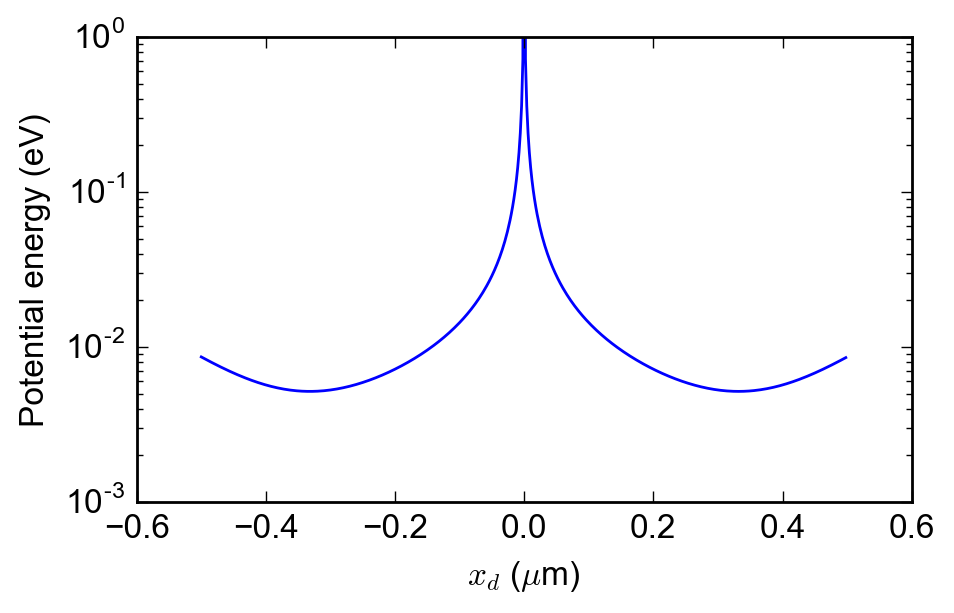

In [38]:
def Ud(xd, V):
    return 1/4. * qe * (trap_curv(V) * np.diag(xd**2) + quartic(V) * np.diag(xd**4)) \
            + qe**2 / (4*np.pi*eps0) * np.diag(1/(np.abs(xd)))

def setup_diff_eqs(xd, V):
    second_deriv = -np.diag(hbar**2/(me*dxd**2) * np.ones(len(xd)-1),k=-1) +\
                   -np.diag(hbar**2/(me*dxd**2) * np.ones(len(xd)-1),k=+1) + \
                   +np.diag(2*hbar**2/(me*dxd**2) * np.ones(len(xd)))

    return second_deriv + Ud(xd,V)
        
plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(xd*1E6, np.diag(Ud(xd, 1.0))/qe)
plt.xlabel("$x_d$ ($\mu$m)")
plt.ylabel("Potential energy (eV)")
plt.yscale('log')
plt.ylim(1E-3, 1E0)

(E2 - E0)/h = 43.92 GHz
(E4 - E2)/h = 44.35 GHz


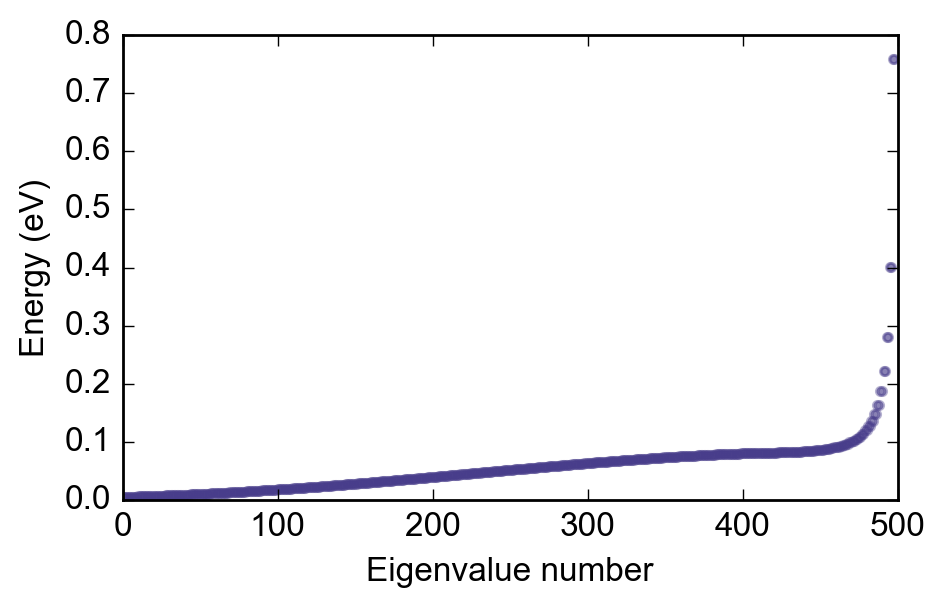

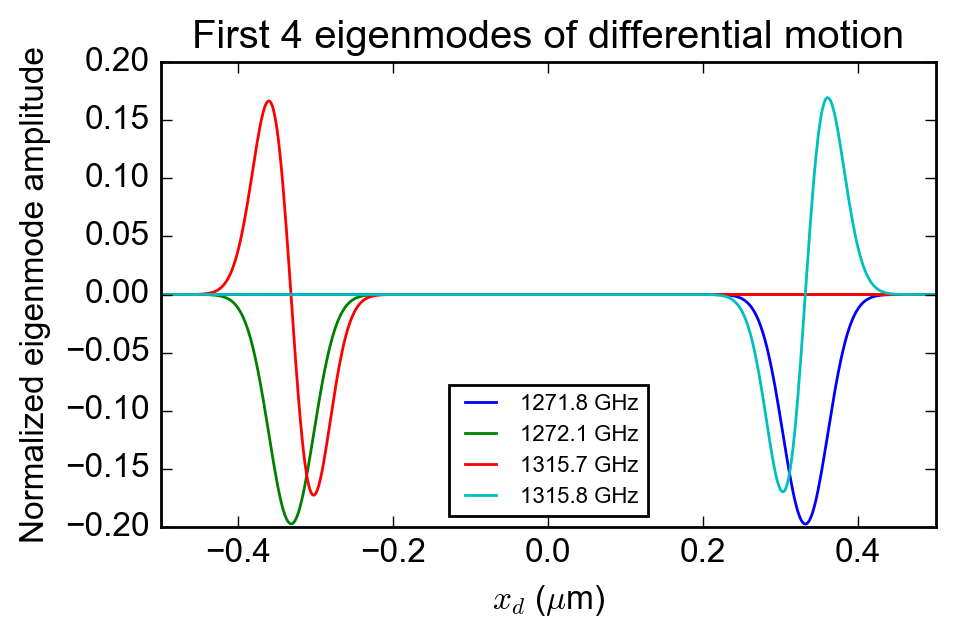

In [39]:
evals_d, evecs_d = np.linalg.eig(setup_diff_eqs(xd, 1.0))
order_d = np.argsort(evals_d)

plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(evals_d[order_d][:-1]/qe, 'o', **common.plot_opt(color='darkslateblue', msize=3))
plt.xlabel("Eigenvalue number")
plt.ylabel("Energy (eV)")

plt.figure(figsize=(5.,3.))
common.configure_axes(12)

for n in range(4):
    plt.plot(xd*1E6, evecs_d[:,order_d[n]], label="%.1f GHz"%(evals_d[order_d[n]]/(2*np.pi*hbar*1E9)))

print("(E2 - E0)/h = %.2f GHz"%((evals_d[order_d[2]]-evals_d[order_d[0]])/(2*np.pi*hbar*1E9)))
print("(E4 - E2)/h = %.2f GHz"%((evals_d[order_d[4]]-evals_d[order_d[2]])/(2*np.pi*hbar*1E9)))
    

plt.legend(loc=0, prop={"size" : 8})
plt.xlim(-0.5, +0.5)
plt.xlabel('$x_d$ ($\mu$m)')
plt.ylabel('Normalized eigenmode amplitude')
plt.title('First 4 eigenmodes of differential motion')

# Let's study a 2D well now

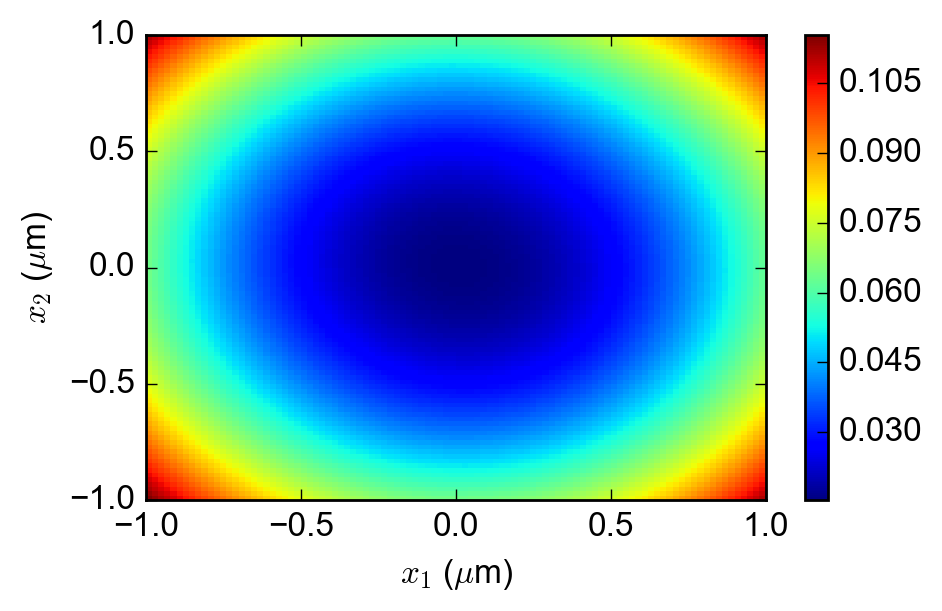

In [33]:
def twod_trap_curv(V): 
    k0x, k0y = 0.1E12, 0.2E12
    return k0x*V, k0y*V

kx, ky = twod_trap_curv(1.0)

X1 = np.linspace(-1E-6, 1E-6, 101)
X2 = np.linspace(-1E-6, 1E-6, 101)
Y1 = np.linspace(-1E-6, 1E-6, 101)
Y2 = np.linspace(-1E-6, 1E-6, 101)

def E(xs): 
    x1, x2, y1, y2 = xs
    return (0.5 * qe * kx * (x1**2 + x2**2) + 0.5 * qe * ky * (y1**2 + y2**2) + \
qe**2/(4*np.pi*eps0) * 1/np.sqrt((x1-x2)**2 + (y1-y2)**2))/qe

x1, x2 = np.meshgrid(X1,X2)
y1 = -0.25E-6
y2 = -y1
#y1, y2 = np.meshgrid(Y1,Y2)

plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.pcolormesh(x1*1E6, x2*1E6, E([x1, x2, y1, y2]))

try:
    for k in range(1):
        xmin, ymin = np.where(E==np.min(E))[k]
        plt.plot(X1[ymin]*1E6, X2[xmin]*1E6, 'ok')
except: 
    pass

plt.colorbar()
plt.xlabel("$x_1$ ($\mu$m)")
plt.ylabel("$x_2$ ($\mu$m)")


In [4]:
import scipy

     fun: 0.007048350826209362
     jac: array([-0.00016038,  0.04593192,  0.00248464,  0.00220128])
 message: 'Optimization terminated successfully.'
    nfev: 126
     nit: 9
    njev: 21
  status: 0
 success: True
       x: array([ -1.53289014e-07,   1.53269472e-07,  -3.73687064e-12,
        -3.73970401e-12])


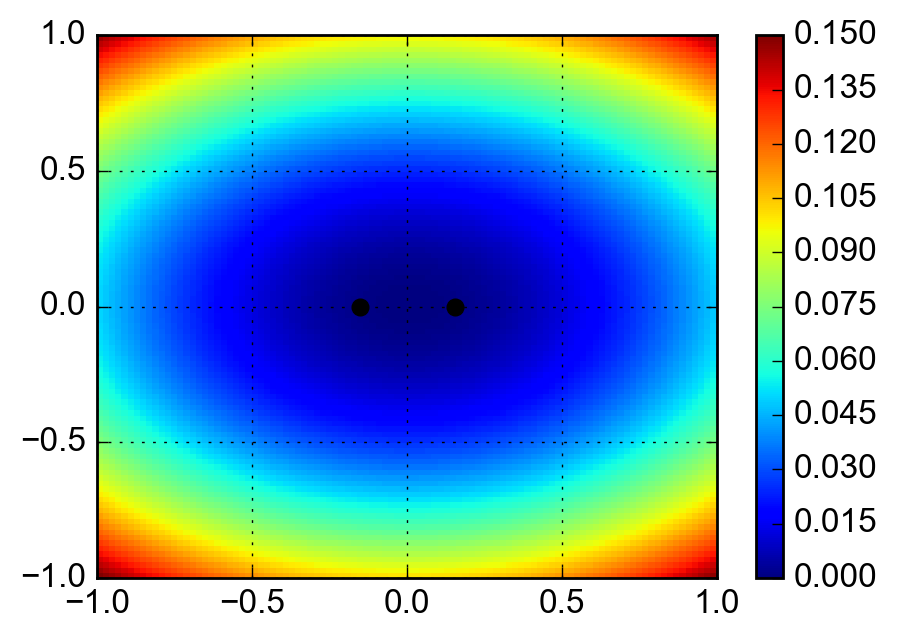

In [42]:
res = scipy.optimize.minimize(E, [-0.123E-6, 0.762E-6, 0.124E-6, 0.144E-6], method='CG', 
                              options={'eps' : 1E-11, 'gtol' : 1E0})
x = res['x'][:2]
y = res['x'][2:]

print(res)

plt.figure(figsize=(5,3.5))
plt.pcolormesh(x1*1E6, x2*1E6, 0.5*kx*x1**2 + 0.5*ky*x2**2)
plt.plot(x*1E6, y*1E6, 'ok')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid()
plt.colorbar();